# Example of Usage of CONFETTI

In [1]:
import numpy as np
import keras
from sklearn import preprocessing
from pathlib import Path
import warnings
# Suppress specific warning
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data

In [2]:
from sktime.datasets import load_UCR_UEA_dataset
dataset = 'BasicMotions'

#Data will load with shape (instances, dimensions, timesteps)
X_train, y_train = load_UCR_UEA_dataset("BasicMotions", split="train", return_type="numpy3d")
X_test, y_test = load_UCR_UEA_dataset("BasicMotions", split="test", return_type="numpy3d")

#Reshape data to (instances, timesteps, dimensions)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[2],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])

#Encode
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

#One Hot the labels for the CNN
y_train_encoded, y_test_encoded = keras.utils.to_categorical(y_train), keras.utils.to_categorical(y_test)


nb_classes = len(np.unique(np.concatenate([y_train,y_test])))
input_shape = X_train.shape[1:] #The input shape for our CNN should be (timesteps, dimensions)

## Model

### Train a Model

In [3]:
#Train model yourself
#from models.fcn import ClassifierFCN
#
#model = ClassifierFCN(input_shape=input_shape, nb_classes=nb_classes, dataset_name=dataset, verbose=False)
#
#model.fit(X_train, y_train_encoded, X_test, y_test_encoded)

### or Load a Trained Model

In [4]:
#Load trained model
# Ensure the path is always relative to the project root
model_path = Path.cwd().parent  / "models" / "trained_models" / dataset / f"{dataset}_fcn.keras"
# Load the model
model = keras.models.load_model(str(model_path))

# Explainer

Firt, we need to obtain the class activation map weights.

In [5]:

import confetti as cam

testing_weights = cam.compute_weights_cam(model, X_test, dataset=dataset, save_weights=True, data_type='testing')

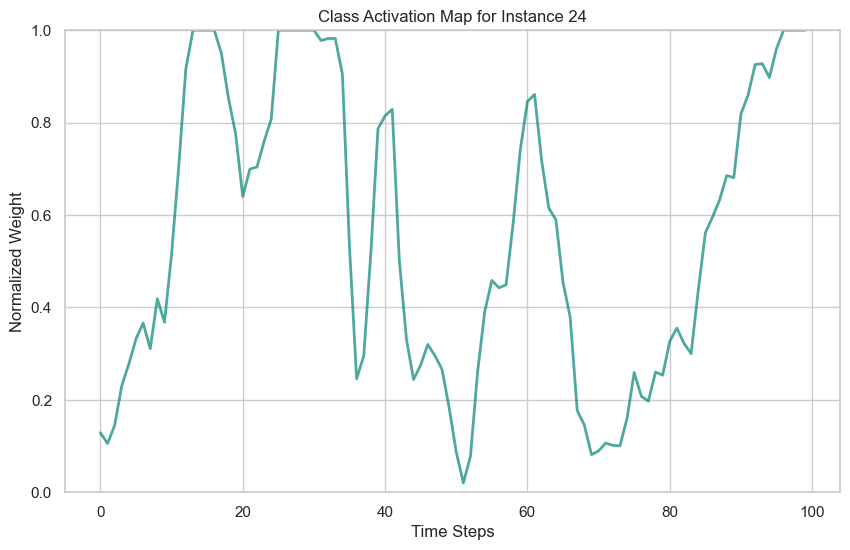

In [6]:
cam.visualize_cam(testing_weights, 24)

We are now ready to create our CONFETTI explainer.

In [7]:
from confetti import CONFETTI

ce = CONFETTI(model_path, X_train, X_test[:1], y_test[:1], y_train, testing_weights)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [8]:
#ce_directory = Path.cwd().parent/ "results" / dataset
#ce.counterfactual_generator(ce_directory, save_counterfactuals=True, optimization=True)

In [ ]:
ce_directory = Path.cwd().parent/ "results" / dataset
ce.parallelized_counterfactual_generator(ce_directory,save_counterfactuals=True,processes=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━

## Visualize the Counterfactuals

In [ ]:
ce.visualize_counterfactuals(24)

In [ ]:
ce.visualize_marks(24)

In [ ]:

import confetti as viz

viz.plot_with_cam(ce,24,weights=testing_weights[24])

# Metrics

In [ ]:
ce.naive_counterfactuals

In [ ]:
from benchmark.evaluations.evaluator import Evaluator
ev = Evaluator('confetti_naive')
cf_metrics, metrics = ev.evaluate_dataset(dataset)

In [ ]:
viz.tradeoff_sparsity_proximity(cf_metrics)